In [4]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def plant_power_with_shade_losses(
    resource_data,
    latitude,
    longitude,
    mount_type,
    gcr,
    dc_capacity_plant,
    power_plant_ac_max,
    dc_loss_fraction,
    gamma_pdc,
    shade_loss_type,
    backtrack=pd.NA,
    max_tracker_angle=pd.NA,
    axis_tilt=pd.NA,
    axis_azimuth=pd.NA,
    fixed_tilt=pd.NA,
    fixed_azimuth=pd.NA,
    n_cells_up=12,
    row_side_num_mods=pd.NA,
    row_height_center=pd.NA,
    row_pitch=pd.NA,
    **kwargs,
    ):

    # Fill in some necessary variales with defaults if there is no value provided
    if pd.isna(row_side_num_mods):
        row_side_num_mods = 1 # default if no value provided

    if pd.isna(row_height_center):
        row_height_center = 1 # default if no value provided

    if pd.isna(row_pitch):
        row_pitch = 2 / gcr # default if no value provided

    # transposition_model = 'perez-driesse'
    transposition_model = 'haydavies'
    # transposition_model = 'isotropic'
    eta_inv_nom = 0.98

    times = resource_data.index 
    loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # surface tilt and azimuth
    if mount_type == 'single-axis':  
        # tracker orientation angles
        singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                                apparent_azimuth=solar_position.azimuth,
                                axis_tilt=axis_tilt,
                                axis_azimuth=axis_azimuth,
                                backtrack=backtrack,
                                gcr=gcr,
                                )
        orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                                **singleaxis_kwargs)
        surface_tilt = orientation.surface_tilt.fillna(0)
        surface_azimuth = orientation.surface_azimuth.fillna(0)
    elif mount_type == 'fixed':
        surface_tilt = float(fixed_tilt)
        surface_azimuth = float(fixed_azimuth)

    # dni and airmass
    dni_extra = pvlib.irradiance.get_extra_radiation(resource_data.index)
    # airmass = pvlib.atmosphere.get_relative_airmass(
    #     solar_position.apparent_zenith,
    #     model='kastenyoung1989'
    # )

    # empty dictionaries to be filled in while looping through the number of modules on the side of each row
    irrad_inf_sh = {} # tilted irradiance 
    fd = {} # diffuse fraction
    fs = {} # shaded fraction
    pnorm = {}
    shade_loss = {}
    pdc = {}
    t_cell = {}
    pdc_shaded = {}
    pdc_inv = {}

    # set the "effective" number of modules on the side of each row
    if shade_loss_type == 'non-linear':
        eff_row_side_num_mods = int(row_side_num_mods)
    elif shade_loss_type == 'non-linear_twin_module':
        # twin modules are treated as effectively two modules with half as many cells each
        eff_row_side_num_mods = int(row_side_num_mods) * 2
        n_cells_up = n_cells_up / 2
    # for linear shade loss, it really doesn't matter how many modules there are on the side of each row, so just run everything once to save time
    elif shade_loss_type == 'linear':
        eff_row_side_num_mods = 1 

    for n in range(0,eff_row_side_num_mods):

        irrad_inf_sh[n] = pvlib.bifacial.infinite_sheds.get_irradiance(
            surface_tilt = surface_tilt, 
            surface_azimuth = surface_azimuth,
            solar_zenith = solar_position.apparent_zenith, 
            solar_azimuth = solar_position.azimuth,
            gcr = gcr/(n+1), # effective gcr is plant gcr divided by position (course) up the row
            height = row_height_center,
            pitch = row_pitch,
            ghi = resource_data.ghi,
            dhi = resource_data.dhi,
            dni = resource_data.dni,
            albedo = resource_data.albedo,
            model = transposition_model,
            dni_extra = dni_extra,
            # TODO: add bifaciliaty later if needed...
        )

        # diffuse fraction
        fd[n] = irrad_inf_sh[n]['poa_front_diffuse'] / irrad_inf_sh[n]['poa_front'] 
        # shaded fraction
        fs[n] = irrad_inf_sh[n]['shaded_fraction_front'] 

        if shade_loss_type == 'linear':
            # shade_loss[n] = fs[n] * (1 - fd[n])
            shade_loss[n] = 0 # linear shade loss should already be included in infinite_sheds.get_irradiance
        else: # 'non-linear' or 'non-linear_twin_module'
            pnorm[n] = np.where(fs[n] < 1/n_cells_up, 1 - (1 - fd[n])*fs[n]*n_cells_up, fd[n])
            shade_loss[n] = 1 - pnorm[n]

        # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
        t_cell[n] = pvlib.temperature.faiman(irrad_inf_sh[n]['poa_front'],
                                        resource_data.temp_air,
                                        resource_data.wind_speed,
        )

        # transient cell temperature, since we are working with intervals shorter than 20 minutes
        t_cell[n] = pvlib.temperature.prilliman(t_cell[n], resource_data.wind_speed)

        # PVWatts dc power
        pdc[n] = pvlib.pvsystem.pvwatts_dc(irrad_inf_sh[n]['poa_front'],
                                        t_cell[n],
                                        dc_capacity_plant,
                                        gamma_pdc)
        pdc_shaded[n] = pdc[n] * (1 - shade_loss[n]) # apply shade losses
        pdc_inv[n] = pdc_shaded[n] * (1 - dc_loss_fraction) # dc power into the inverter after losses
        
    # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc0 = power_plant_ac_max/eta_inv_nom 

    # average the dc power across n positions up the row
    pdc_inv_total = pd.concat(pdc_inv, axis=1, sort=False).mean(axis=1)

    # ac power with PVWatts inverter model
    power_ac = pvlib.inverter.pvwatts(pdc_inv_total, pdc0, eta_inv_nom)

    return power_ac, pnorm, fs

Load plant specifications:

In [6]:
filename = 'plant_specs_pvpmc.csv'
header = 4 # row (0-index, so starting count at 0) of the header
index_col = 'None'
plants_df = pd.read_csv(filename, header=header) # read in as a Pandas DataFrame
num_plants = len(plants_df.index) # number of plants
plants_df.head()

,Variable:,unit_id,unit_name,other_name,owner_name,offtaker_name,asset_type,cod,latitude,longitude,...,modules_per_string,strings_per_inverter,num_inverters,module_model,inverter_model,shade_loss_type,n_cells_up,module_length,module_width,module_spec_url
0,NaN,100,Generic Fixed Plant,NaN,NaN,NaN,plant,NaN,32.0000,-84.0000,...,NaN,NaN,NaN,NaN,NaN,non-linear,12,NaN,NaN,NaN
1,NaN,9069,Simon Solar,Simon,NaN,NaN,plant,NaN,33.6762,-83.6760,...,NaN,NaN,39.0,NaN,NaN,non-linear,12,NaN,NaN,NaN
2,NaN,9068,SR_CO,SR Kersey,NaN,NaN,plant,NaN,40.3864,-104.5512,...,NaN,NaN,2.0,NaN,NaN,linear,1,NaN,NaN,NaN


In [7]:
# start = '2024-01-04 12:00Z'
# end = '2024-01-05 00:00Z'   
# ## API key credentials are stored in a separate text file
# # full path and filename of text file with email on first line and api key on second line
# with open('CONFIDENTIAL_solaranywhere_key_SPC_hobbs.txt') as f: 
#     api_key = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces

# time_resolution = 15 # time resolution in minutes, can be 15, 30, 60 for standard license, 5 min with upgrade
# source = 'SolarAnywhereLatest'

# # empty dictionaries to store data for multiple sites
# sa_data_dict = {}
# sa_metadata_dict = {}

# for x in range(0,num_plants):
#     latitude = plants_df.iloc[x]['latitude_solaranywhere'] 
#     longitude = plants_df.iloc[x]['longitude_solaranywhere']
#     print('getting site number: ' + str(x+1))
#     sa_data_dict[x], sa_metadata_dict[x] = pvlib.iotools.get_solaranywhere(
#         latitude, longitude, api_key, start, end, source, time_resolution,
#     )

In [8]:
# pick plant number:
x = 1

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.iloc[x].dropna().to_dict() 
# plant_data = plants_df.iloc[x].to_dict() 

In [9]:
# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-21 6:00', '2021-12-21 10:00', freq='5T', tz='Etc/GMT+5')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 25 # use 25 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

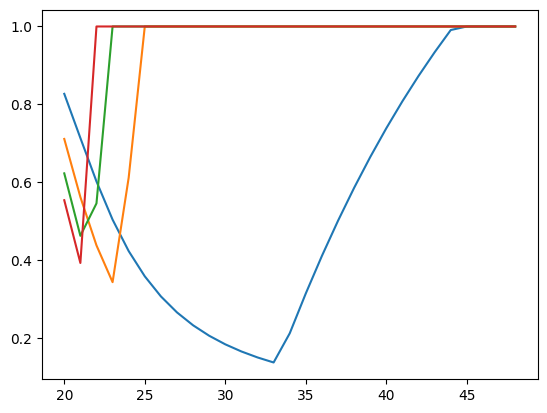

In [10]:
# change to 2P c-Si twin half-cut
plant_data_new = { **plant_data,
                  'n_cells_up': 12,
                  'row_side_num_mods':2,
                  'shade_loss_type':'non-linear_twin_module',
                  'cell_type':'crystalline',
                  }
power_ac_new2, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data_new)
plt.plot(pnorm[0])
plt.plot(pnorm[1])
plt.plot(pnorm[2])
plt.plot(pnorm[3])
plt.show()

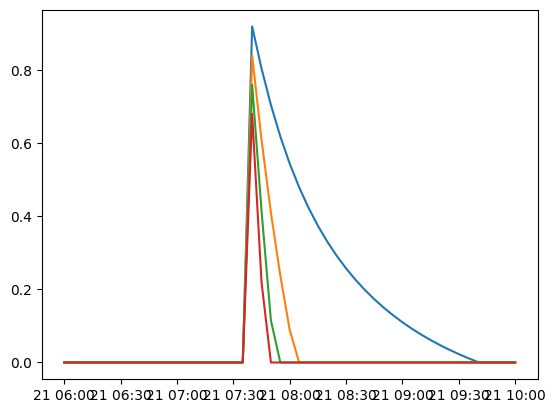

In [11]:
plt.plot(fs[0])
plt.plot(fs[1])
plt.plot(fs[2])
plt.plot(fs[3])
plt.show()

<Axes: >

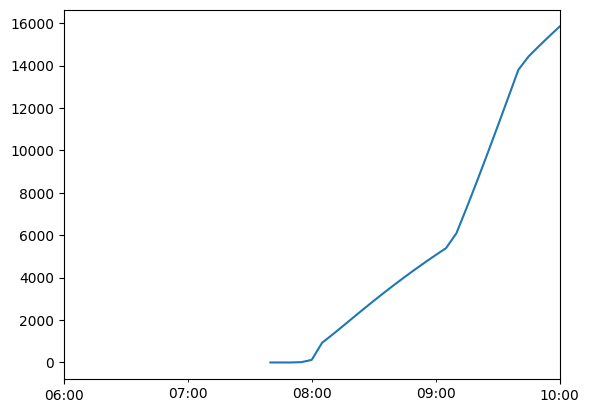

In [12]:

# resource_data = sa_data_dict[x]
# make sure plant location matches resource data
# plant_data.update({'latitude': resource_metadata['latitude'], 'longitude': resource_metadata['longitude']})

# run power model
power_ac, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data)
power_ac.plot()

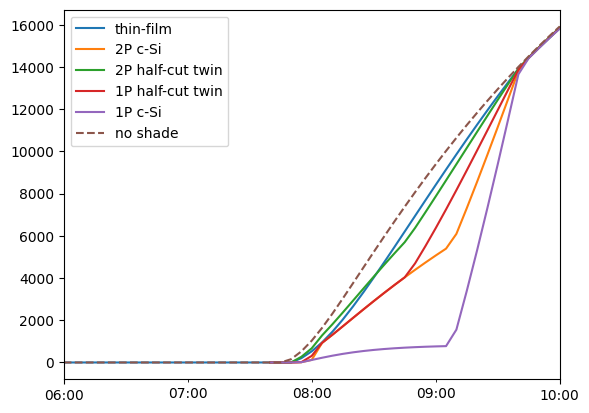

In [13]:
plant_data_new = { **plant_data,
                  'cell_type': 'thin-film',
                  'shade_loss_type': 'linear',
                  }
power_ac_new0, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data_new)

# change to 2P c-Si
plant_data_new = { **plant_data,
                  'n_cells_up': 12,
                  'row_side_num_mods':2,
                  'shade_loss_type':'non-linear',
                  'cell_type':'crystalline',
                  }
power_ac_new1, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data_new)

# change to 2P c-Si twin half-cut
plant_data_new = { **plant_data,
                  'n_cells_up': 12,
                  'row_side_num_mods':2,
                  'shade_loss_type':'non-linear_twin_module',
                  'cell_type':'crystalline',
                  }
power_ac_new2, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data_new)

# 1P c-Si twin half-cut
plant_data_new = { **plant_data,
                  'n_cells_up': 12,
                  'row_side_num_mods':1,
                  'shade_loss_type':'non-linear_twin_module',
                  'cell_type':'crystalline',
                  }
power_ac_new3, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data_new)

# regular 1P c-Si
plant_data_new = { **plant_data,
                  'n_cells_up': 12,
                  'row_side_num_mods':1,
                  'shade_loss_type':'non-linear',
                  'cell_type':'crystalline',
                  }
power_ac_new4, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_new5, pnorm, fs = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot it all
power_ac_new0.plot()
power_ac_new1.plot()
power_ac_new2.plot()
power_ac_new3.plot()
power_ac_new4.plot()
power_ac_new5.plot(linestyle='--')
plt.legend(['thin-film', '2P c-Si', '2P half-cut twin', '1P half-cut twin', '1P c-Si', 'no shade'])
plt.show()

Why is 2P half-cut better than thin-film in early morning and late afternoon? Maybe reflected irradiance under the leading rows? Setting albedo to zero doesn't change it, so maybe not...

Update: It's because `gcr = gcr/(n+1), # effective gcr is plant gcr divided by position (course) up the row` isn't quite right. I think it works for the very top string(s) (course), but not lower ones. Here's a modified excerpt from https://gist.github.com/williamhobbs/9d1fb23a64f1921400938250af6a67f0:

<!-- > <img src="images/2P_GCR_illustration.png" alt="2P GCR Illustration" width="500" /> -->
> ![](images/2P_GCR_illustration.png)
> ![](https://user-images.githubusercontent.com/45701090/273331244-80b91f14-2844-4629-b035-28434ef4e401.png)
>The row-to-row pitch $ P $ and collector width $ L $ can be used to calculate the GCR for ~~the bottom strings~~ _all strings_ [_I previously thought it worked for just the bootom string_] as:
>
>$$ GCR = {L \over P} $$
>
>And then for the top row:
>
>$$ GCR_{top} = {L_{top} \over P_{top}} $$
>
>where $ L_{top} = L/2 $, and $ P_{top} = P $, because the bottom row does not impact the top row's effective GCR, so:
>
>$$ GCR_{top} = {L/2 \over P} $$

